
# 03a Composition-Only Popularity Model

In this notebook we focus on a very limited set of compositional features (`tempo`, `time_signature`, `key`, `mode`, `duration_ms`) to see whether they can explain or predict the popularity of a track.  
We work directly with the dataset already preprocessed in the earlier steps, train a Ridge regression model using only these variables, and then analyze the results to evaluate how much predictive power they actually provide.


## 0) Environment & Data Loading


In [9]:
!pip -q install pyspark


from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql import SparkSession, functions as F, types as T

spark = SparkSession.builder.appName("FeatureImportance").getOrCreate()

SILVER = "file:///content/drive/MyDrive/data/spotify/silver_parquet"
df = spark.read.parquet(SILVER)

print("Rows:", df.count())
df.printSchema()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Rows: 89620
root
 |-- track_genre: string (nullable = true)
 |-- track_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- popularity_z: double (nulla


## 1) Configuration

We restrict to the following **compositional** features and the target `popularity`.


In [12]:

TARGET_COL = "popularity"
COMPOSITIONAL_FEATURES = ["tempo", "time_signature", "key", "mode", "duration_ms"]

# Ridge hyperparameters
RIDGE_REG = 1.0          # L2 strength (regParam)
RIDGE_STD = True         # standardize inputs inside the LR estimator
TEST_SPLIT_SEED = 42

# Build the dataframe for the composition features
cols = COMPOSITIONAL_FEATURES + [TARGET_COL]
df_comp = df.select(*cols)

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")



## 2) Feature Distributions

We quickly visualize how the compositional features are distributed.  


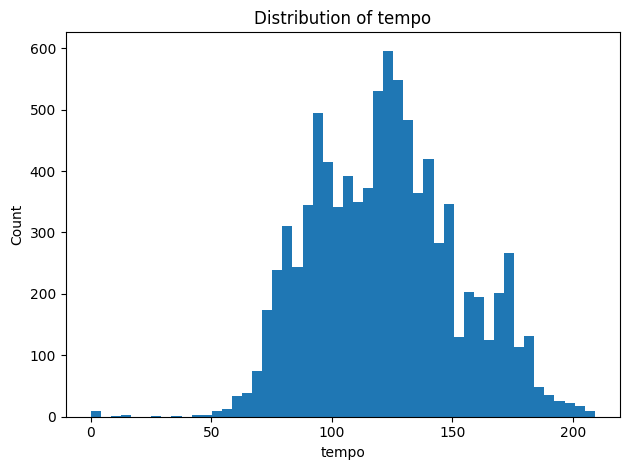

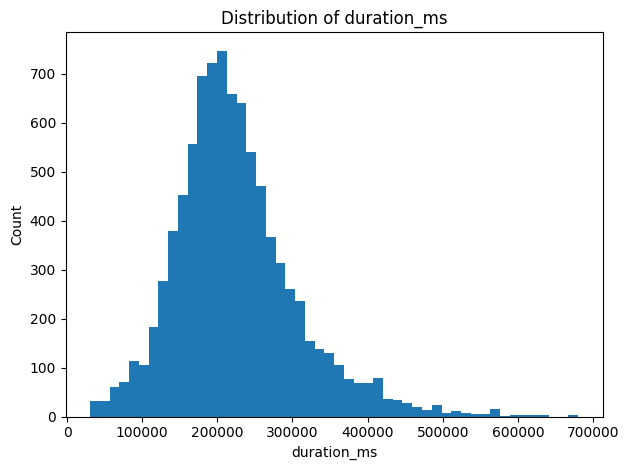

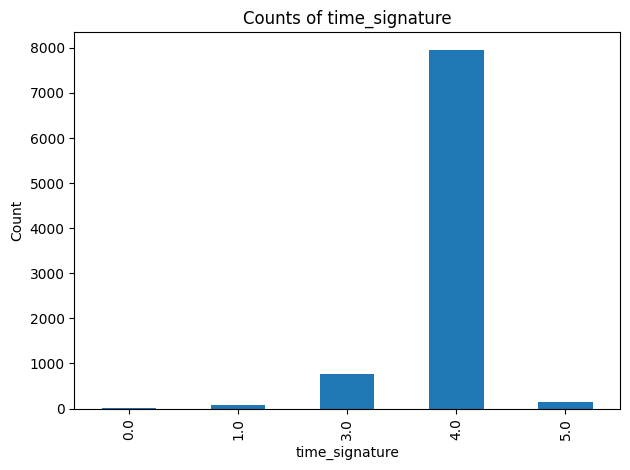

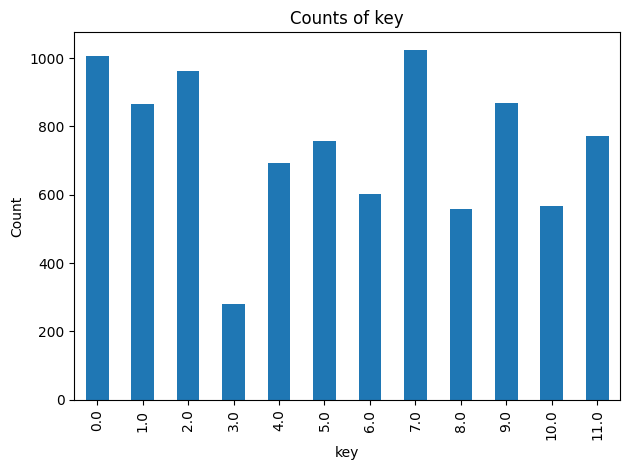

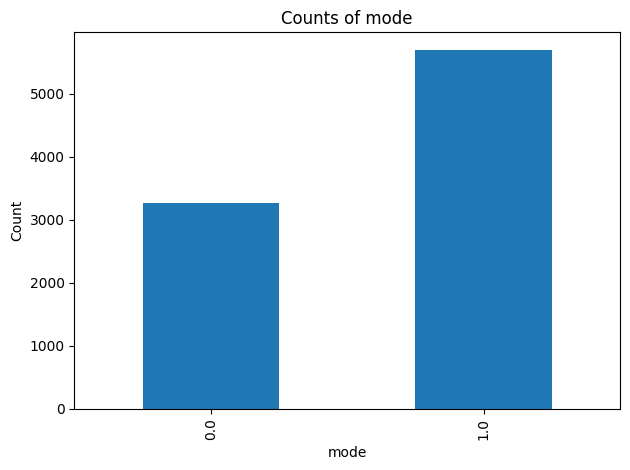

In [13]:

import pandas as pd
import matplotlib.pyplot as plt


plot_sample = df_comp.sample(False, 0.10, seed=TEST_SPLIT_SEED).toPandas()

# Numeric histograms
for col in ["tempo", "duration_ms"]:
    if col in plot_sample.columns:
        plt.figure()
        plot_sample[col].dropna().plot(kind="hist", bins=50)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col); plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

# Discrete/categorical-like bar charts
for col in ["time_signature", "key", "mode"]:
    if col in plot_sample.columns:
        counts = plot_sample[col].value_counts().sort_index()
        plt.figure()
        counts.plot(kind="bar")
        plt.title(f"Counts of {col}")
        plt.xlabel(col); plt.ylabel("Count")
        plt.tight_layout()
        plt.show()


Tempo and duration follow roughly bell-shaped distributions with some outliers, which suggests a concentration
of songs around typical values but also the presence of unusual tracks. Time signature is dominated by 4/4,
as expected in most popular music, while the distribution of keys and modes shows a more balanced variety.
These observations confirm that the dataset is diverse but still reflects common patterns in contemporary
music composition.


## 3) Ridge Regression

We use `LinearRegression` with **L2** penalty (`elasticNetParam=0.0`).

In [14]:

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

assembler = VectorAssembler(inputCols=COMPOSITIONAL_FEATURES, outputCol="features")

ridge = LinearRegression(
    featuresCol="features",
    labelCol=TARGET_COL,
    regParam=RIDGE_REG,
    elasticNetParam=0.0,   # 0.0 -> Ridge (L2)
    standardization=RIDGE_STD
)

pipeline = Pipeline(stages=[assembler, ridge])

train_df, test_df = df_comp.randomSplit([0.8, 0.2], seed=TEST_SPLIT_SEED)
model = pipeline.fit(train_df)
pred = model.transform(test_df)

e_rmse = RegressionEvaluator(labelCol=TARGET_COL, predictionCol="prediction", metricName="rmse")
e_r2   = RegressionEvaluator(labelCol=TARGET_COL, predictionCol="prediction", metricName="r2")

rmse = e_rmse.evaluate(pred)
r2   = e_r2.evaluate(pred)

print(f"[Ridge | Composition-only] RMSE: {rmse:.4f}  |  R²: {r2:.4f}")


[Ridge | Composition-only] RMSE: 19.7483  |  R²: 0.0022


### Coefficients & Intercept

In [15]:

from pyspark.ml.regression import LinearRegressionModel

lin_model = None
for s in model.stages:
    if isinstance(s, LinearRegressionModel):
        lin_model = s
        break

if lin_model is None:
    raise RuntimeError("Could not extract LinearRegressionModel from the pipeline.")

coef_map = list(zip(COMPOSITIONAL_FEATURES, lin_model.coefficients.toArray()))
coef_map


[('tempo', np.float64(0.0032589148112271834)),
 ('time_signature', np.float64(1.4712988673613534)),
 ('key', np.float64(0.009665618591522271)),
 ('mode', np.float64(-0.6011674483923316)),
 ('duration_ms', np.float64(-7.061207543106972e-06))]

### Predicted vs Actual (test)

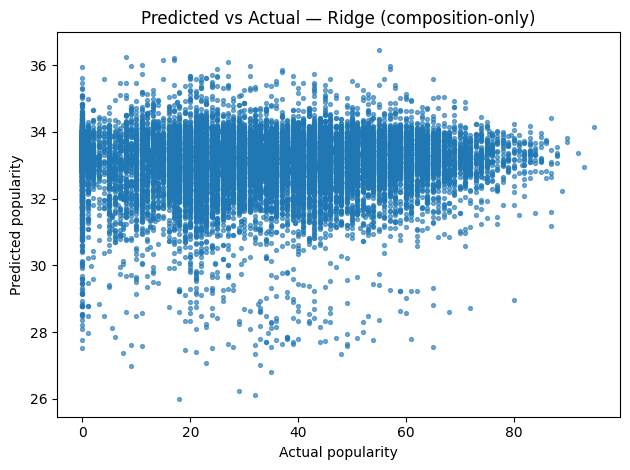

In [16]:

pdf = pred.select(TARGET_COL, "prediction").toPandas()
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(pdf[TARGET_COL], pdf["prediction"], s=8, alpha=0.6)
plt.xlabel("Actual popularity")
plt.ylabel("Predicted popularity")
plt.title("Predicted vs Actual — Ridge (composition-only)")
plt.tight_layout()
plt.show()


## 4) Results & Discussion

The Ridge regression model trained only on compositional features (`tempo`, `time_signature`, `key`, `mode`, `duration_ms`) shows very limited predictive power for popularity.  
The reported **RMSE is around 19**, which is relatively large compared to the target scale (0–100), while the **R² is approximately 0**, indicating that the model fails to capture meaningful variance in popularity.

This outcome is not surprising: popularity is influenced by a wide range of factors that go far beyond basic musical composition.  
While features like tempo or time signature describe structural aspects of the track, they do not account for production quality, cultural trends, artist reputation, playlisting, or promotional dynamics.  
The scatter plot of predicted vs. actual values further confirms this, showing that predictions are essentially clustered around the mean, without reflecting the true variability in the data.

---


This demonstrates that **composition-only features are insufficient** for modeling popularity in a reliable way.  
To obtain stronger predictive performance, we will try to include a **broader set of features**, and perform a **feature-importance analysis**, potentially revealing which dimensions actually drive popularity.




---
_This notebook was generated on **2025-09-29 13:08 UTC**._
